# Homework Workshop 2

Importo los modulos necesarios

In [9]:
import os
import random

from dotenv import load_dotenv
from openai import OpenAI

Defino métodos/funciones/objetos necesarios

In [2]:
known_weather_data = {
    'berlin': 20.0
}

def get_weather(city: str) -> float:
    city = city.strip().lower()

    if city in known_weather_data:
        return known_weather_data[city]

    return round(random.uniform(-5, 35), 1)

## Q1. Define function description

In [3]:
get_weather_tool = {
    "type": "function",
    "name": "get_weather",    # <-- TODO1
    "description": "Returns the temperature for the specified city, using stored or randomly generated data.",    # <-- TODO2
    "parameters": {
        "type": "object",
        "properties": {
            "city": {    # <-- TODO3
                "type": "string",
                "description": "Name of the city for which the weather should be retrieved"    # <-- TODO4
            }
        },
        "required": ["city"],    # <-- TODO5
        "additionalProperties": False
    }
}

In [7]:
load_dotenv()

openai_key = os.getenv("OPENAI_API_KEY")

if openai_key is None:
    print("⚠️ La variable OPENAI_API_KEY no está definida en el archivo .env")
else:
    print("✅ La variable OPENAI_API_KEY está definida correctamente.")

✅ La variable OPENAI_API_KEY está definida correctamente.


In [17]:
input_user = input("Please enter your question about the weather or a city:")

question = f"What's the weather like in {input_user}?"

developer_prompt = """
You are an assistant that helps users check the weather in different cities.
Use the `get_weather` function to retrieve the temperature for the city the user mentions.
If the user doesn't specify a city, ask them to provide one before using the tool.
""".strip()


tools = [get_weather_tool]

chat_messages = [
    {"role": "developer", "content": developer_prompt},
    {"role": "user", "content": question}
]

client = OpenAI()

response = client.responses.create(
    model='gpt-4o-mini',
    input=chat_messages,
    tools=tools
)
response.output

Please enter your question about the weather or a city: Paraguay


[ResponseOutputMessage(id='msg_6875c30ea6dc8191a490523a66f5dd360918c1b6cf890781', content=[ResponseOutputText(annotations=[], text="Paraguay is a country, not a city. Could you please specify a city within Paraguay for which you'd like to know the weather?", type='output_text', logprobs=[])], role='assistant', status='completed', type='message')]

## Q2. Adding another tool

In [18]:
def set_weather(city: str, temp: float) -> None:
    city = city.strip().lower()
    known_weather_data[city] = temp
    return 'OK'

In [19]:
set_weather_tool = {
    "type": "function",
    "name": "set_weather",    
    "description": "Set the temperature for the specified city",
    "parameters": {
        "type": "object",
        "properties": {
            "city": {   
                "type": "string",
                "description": "Name of the city for which the weather should be set"
            },
            "temp": {    
                "type": "number",
                "description": "Temperature value to set for the city"
            }
        },
        "required": ["city", "temp"],
        "additionalProperties": False
    }
}

In [20]:
question = "Set the temperature for Asunción to 28.5 degrees."

developer_prompt = """
You are an assistant that helps users check and update the weather information for different cities.

- Use the `get_weather` function to retrieve the current temperature for the city the user mentions.
- Use the `set_weather` function to update or set the temperature for a city when the user provides a new temperature.
- If the user doesn't specify a city, ask them to provide one before using any tool.
- Always clarify if the information provided is incomplete before calling a tool.
""".strip()

tools = [get_weather_tool, set_weather_tool]

chat_messages = [
    {"role": "developer", "content": developer_prompt},
    {"role": "user", "content": question}
]

client = OpenAI()

response = client.responses.create(
    model='gpt-4o-mini',
    input=chat_messages,
    tools=tools
)
response.output

[ResponseFunctionToolCall(arguments='{"city":"Asunción","temp":28.5}', call_id='call_qXanZX5Kvon6NNGij6AiZOMd', name='set_weather', type='function_call', id='fc_6875c62af598819e80d4c91500f1e5b50b8a1f391ecca098', status='completed')]

## Q3. Install FastMCP

In [21]:
! uv add fastmcp

Resolved 132 packages in 7.04s                                       
Prepared 13 packages in 1.19s                                            
Installed 23 packages in 1.25s                              
 + authlib==1.6.0
 + click==8.2.1
 + cryptography==45.0.5
 + cyclopts==3.22.2
 + dnspython==2.7.0
 + docstring-parser==0.16
 + docutils==0.21.2
 + email-validator==2.2.0
 + exceptiongroup==1.3.0
 + fastmcp==2.10.5
 + httpx-sse==0.4.1
 + markdown-it-py==3.0.0
 + mcp==1.11.0
 + mdurl==0.1.2
 + openapi-pydantic==0.5.1
 + pydantic-settings==2.10.1
 + pyperclip==1.9.0
 + python-multipart==0.0.20
 + rich==14.0.0
 + rich-rst==1.3.1
 + sse-starlette==2.4.1
 + starlette==0.47.1
 + uvicorn==0.35.0


In [22]:
! fastmcp version

FastMCP version:                                                          2.10.5
MCP version:                                                              1.11.0
Python version:                                                           3.13.3
Platform:          Linux-5.15.153.1-microsoft-standard-WSL2-x86_64-with-glibc2.…
FastMCP root path: /home/joviedo/github-repos/llm-zoomcamp-knowledge-base/hw_wo…


In [23]:
import fastmcp

fastmcp.__version__

'2.10.5'

## Q4. Simple MCP Server

In [25]:
! tree

/home/joviedo/.local/share/uv/python/cpython-3.13.3-linux-x86_64-gnu/lib/python3.13/pty.py:95: DeprecationWarning: This process (pid=2971) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


.
├── hw_workshop2_answers.ipynb
└── weather_server.py

0 directories, 2 files


In [29]:
! cat weather_server.py

# weather_server.py
import random
from fastmcp import FastMCP

mcp = FastMCP("Demo 🚀")

known_weather_data = {
    'berlin': 20.0
}

@mcp.tool
def get_weather(city: str) -> float:
    """
    Retrieves the temperature for a specified city.

    Parameters:
        city (str): The name of the city for which to retrieve weather data.

    Returns:
        float: The temperature associated with the city.
    """
    city = city.strip().lower()

    if city in known_weather_data:
        return known_weather_data[city]

    return round(random.uniform(-5, 35), 1)

@mcp.tool
def set_weather(city: str, temp: float) -> None:
    """
    Sets the temperature for a specified city.

    Parameters:
        city (str): The name of the city for which to set the weather data.
        temp (float): The temperature to associate with the city.

    Returns:
        str: A confirmation string 'OK' indicating successful update.
    """
    city = city.strip().lower()
    known_weather_data[city] = temp


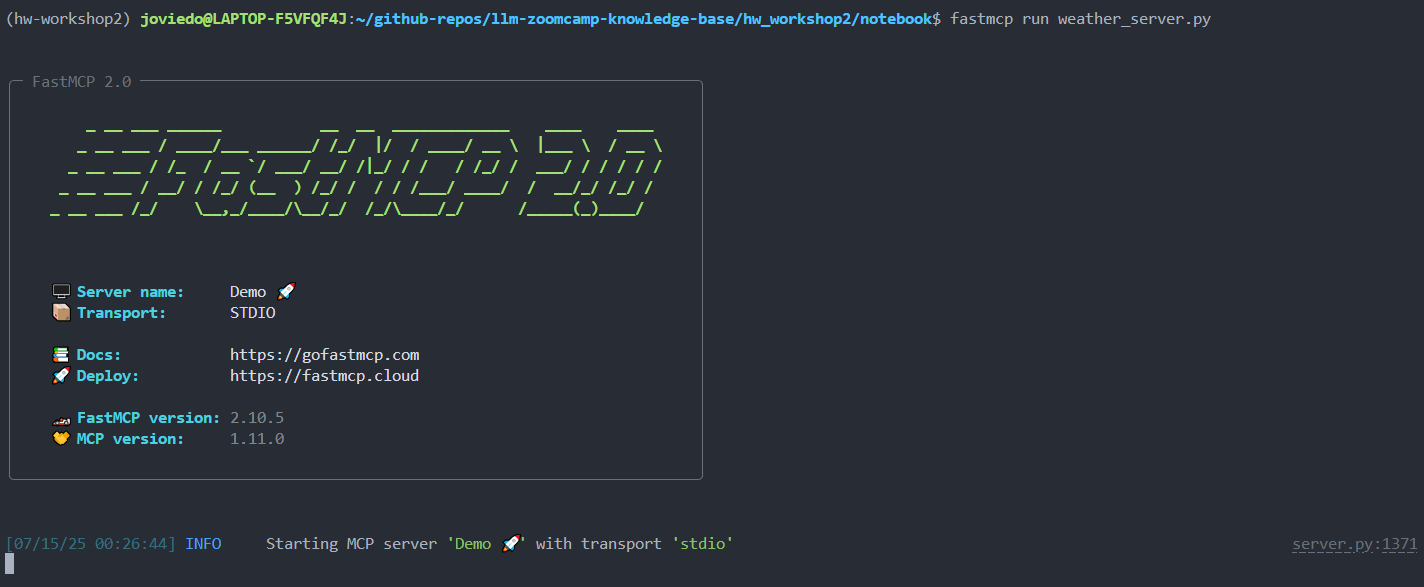

## Q5. Protocol

**Opción 1**: Podemos enviar las peticiones directamente desde la terminal una vez que el servidor de FastMCP esté en ejecución.

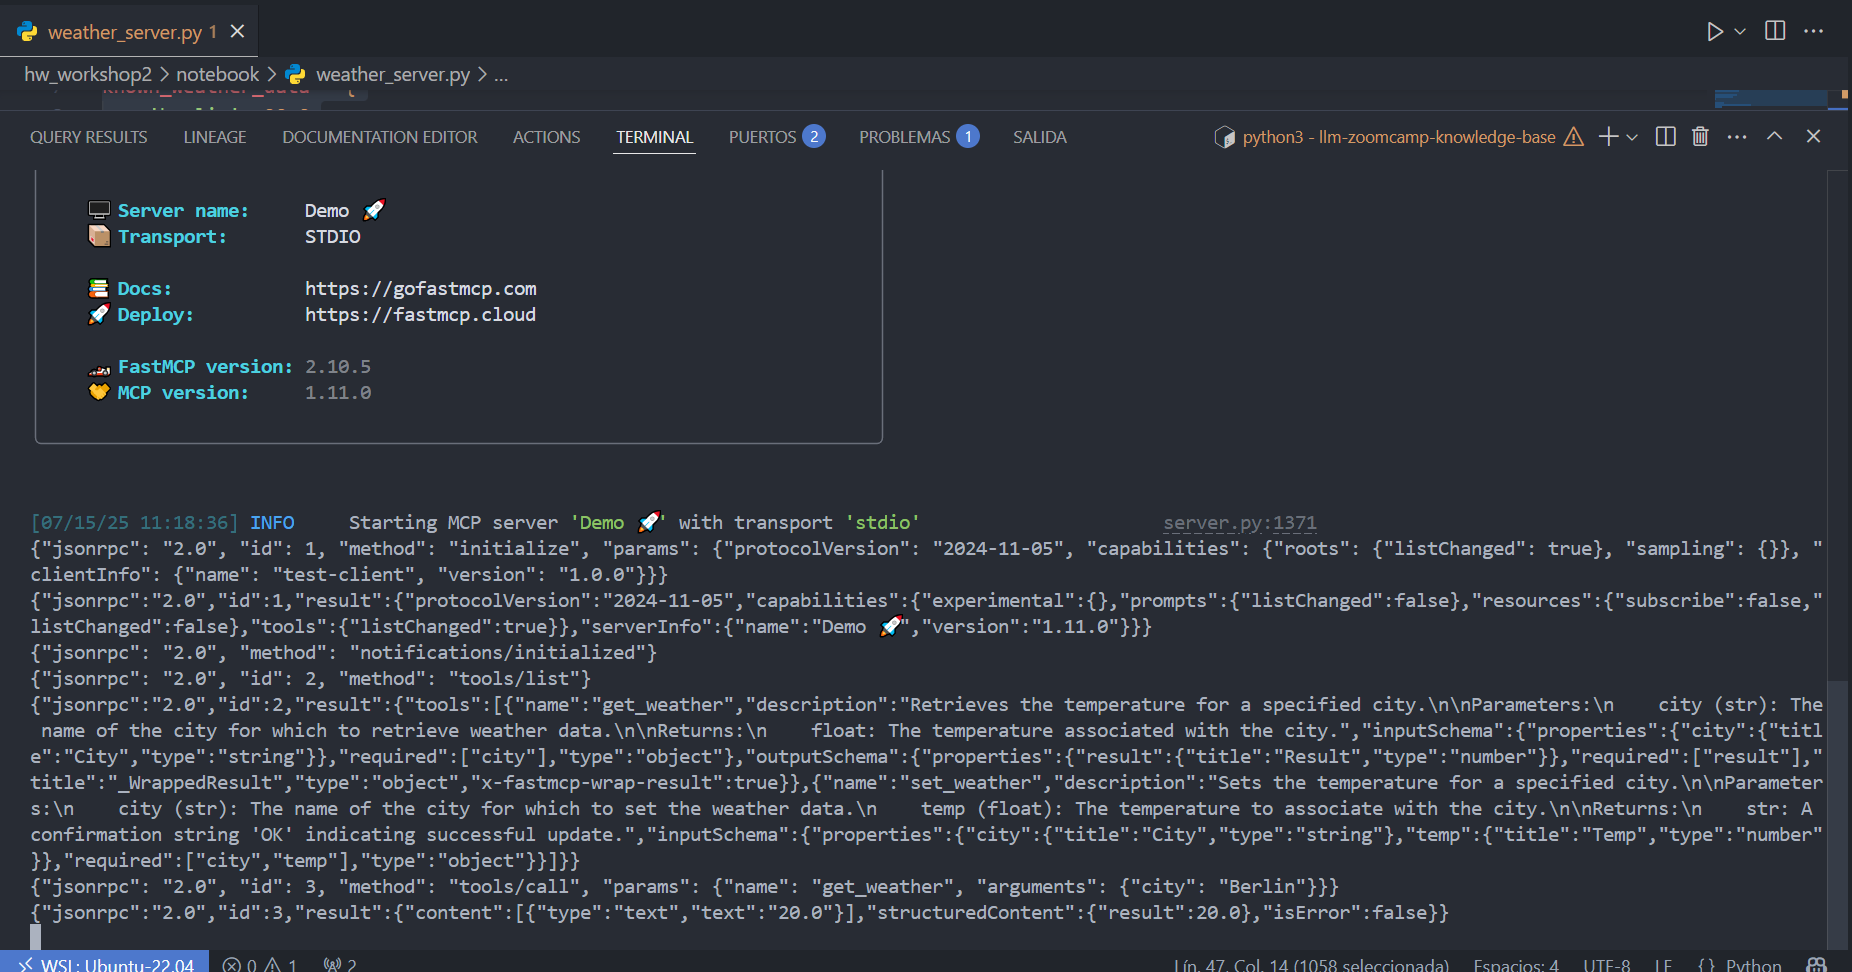

**Opción 2**: En lugar de correr el servidor FastMCP como un script externo, podemos definirlo y ejecutarlo directamente dentro del notebook. Esto nos permite probar herramientas (tools) como get_weather sin necesidad de lanzar un proceso separado.

A continuación, definimos el servidor MCP y conectamos un cliente al mismo objeto en memoria para realizar llamadas a funciones registradas.

In [45]:
import random
from fastmcp import FastMCP

mcp = FastMCP("Demo 🚀")

known_weather_data = {
    'berlin': 20.0
}

@mcp.tool
def get_weather(city: str) -> float:
    """
    Retrieves the temperature for a specified city.

    Parameters:
        city (str): The name of the city for which to retrieve weather data.

    Returns:
        float: The temperature associated with the city.
    """
    city = city.strip().lower()

    if city in known_weather_data:
        return known_weather_data[city]

    return round(random.uniform(-5, 35), 1)

@mcp.tool
def set_weather(city: str, temp: float) -> None:
    """
    Sets the temperature for a specified city.

    Parameters:
        city (str): The name of the city for which to set the weather data.
        temp (float): The temperature to associate with the city.

    Returns:
        str: A confirmation string 'OK' indicating successful update.
    """
    city = city.strip().lower()
    known_weather_data[city] = temp
    return 'OK'

In [46]:
from fastmcp import Client

async def call_weather_tool_in_notebook():
    async with Client(mcp) as client:  # usas el objeto del mismo notebook
        result = await client.call_tool("get_weather", {"city": "Berlin"})
        print("Resultado:", result)

await call_weather_tool_in_notebook()

Resultado: CallToolResult(content=[TextContent(type='text', text='20.0', annotations=None, meta=None)], structured_content={'result': 20.0}, data=20.0, is_error=False)


**Opción 3**: Usar subprocess para enviar manualmente por stdin

In [47]:
import subprocess
import json

# Comando para iniciar el servidor (por ejemplo weather_server.py)
proc = subprocess.Popen(
    ["python", "weather_server.py"],
    stdin=subprocess.PIPE,
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE,
    text=True
)

# Mensaje JSON-RPC de inicialización
init_message = {
    "jsonrpc": "2.0",
    "id": 1,
    "method": "initialize",
    "params": {
        "protocolVersion": "2024-11-05",
        "capabilities": {
            "roots": {"listChanged": True},
            "sampling": {}
        },
        "clientInfo": {
            "name": "test-client",
            "version": "1.0.0"
        }
    }
}

# Enviar por stdin
proc.stdin.write(json.dumps(init_message) + "\n")
proc.stdin.flush()

# Leer respuesta
response = proc.stdout.readline()
parsed = json.loads(response)
print("Respuesta del servidor:", json.dumps(parsed, indent=4, ensure_ascii=False))

Respuesta del servidor: {
    "jsonrpc": "2.0",
    "id": 1,
    "result": {
        "protocolVersion": "2024-11-05",
        "capabilities": {
            "experimental": {},
            "prompts": {
                "listChanged": false
            },
            "resources": {
                "subscribe": false,
                "listChanged": false
            },
            "tools": {
                "listChanged": true
            }
        },
        "serverInfo": {
            "name": "Demo 🚀",
            "version": "1.11.0"
        }
    }
}


In [48]:
initialized_message = {
    "jsonrpc": "2.0",
    "method": "notifications/initialized"
}

# Enviar por stdin
proc.stdin.write(json.dumps(initialized_message) + "\n")
proc.stdin.flush()

print("Notificación 'initialized' enviada correctamente.")

Notificación 'initialized' enviada correctamente.


In [49]:
tools_list_message = {
    "jsonrpc": "2.0", 
    "id": 2, 
    "method": "tools/list"
}

# Enviar por stdin
proc.stdin.write(json.dumps(tools_list_message) + "\n")
proc.stdin.flush()

# Leer respuesta
response = proc.stdout.readline()
parsed = json.loads(response)
print("Respuesta del servidor:", json.dumps(parsed, indent=4, ensure_ascii=False))

Respuesta del servidor: {
    "jsonrpc": "2.0",
    "id": 2,
    "result": {
        "tools": [
            {
                "name": "get_weather",
                "description": "Retrieves the temperature for a specified city.\n\nParameters:\n    city (str): The name of the city for which to retrieve weather data.\n\nReturns:\n    float: The temperature associated with the city.",
                "inputSchema": {
                    "properties": {
                        "city": {
                            "title": "City",
                            "type": "string"
                        }
                    },
                    "required": [
                        "city"
                    ],
                    "type": "object"
                },
                "outputSchema": {
                    "properties": {
                        "result": {
                            "title": "Result",
                            "type": "number"
                        }
    

In [50]:
request = {"jsonrpc": "2.0", "id": 3, "method": "tools/call", "params": {"name": "get_weather", "arguments": {"city": "Berlin"}}}

# Enviar por stdin
proc.stdin.write(json.dumps(request) + "\n")
proc.stdin.flush()

# Leer respuesta
response = proc.stdout.readline()
parsed = json.loads(response)
print("Respuesta del servidor:", json.dumps(parsed, indent=4, ensure_ascii=False))

Respuesta del servidor: {
    "jsonrpc": "2.0",
    "id": 3,
    "result": {
        "content": [
            {
                "type": "text",
                "text": "20.0"
            }
        ],
        "structuredContent": {
            "result": 20.0
        },
        "isError": false
    }
}


## Q6. Client

Aunque es posible enviar comandos manualmente al servidor MCP desde la terminal utilizando `stdin` y `stdout`, este método no es el más práctico ni escalable para aplicaciones reales.

En la práctica, usamos un **cliente MCP**, que nos permite comunicarnos de manera estructurada y programática con el servidor. La librería `fastmcp` proporciona soporte para crear este tipo de clientes de forma sencilla.

A continuación, se muestra cómo usar un cliente MCP dentro de un cuaderno de Jupyter para listar las herramientas disponibles en el servidor:

In [56]:
import weather_server
from fastmcp import Client

async def call_tool_list():
    async with Client(weather_server.mcp) as mcp_client:
        tools = await mcp_client.list_tools()
        print(f"Herramientas disponibles: {tools}")

In [57]:
await call_tool_list()

Herramientas disponibles: [Tool(name='get_weather', title=None, description='Retrieves the temperature for a specified city.\n\nParameters:\n    city (str): The name of the city for which to retrieve weather data.\n\nReturns:\n    float: The temperature associated with the city.', inputSchema={'properties': {'city': {'title': 'City', 'type': 'string'}}, 'required': ['city'], 'type': 'object'}, outputSchema={'properties': {'result': {'title': 'Result', 'type': 'number'}}, 'required': ['result'], 'title': '_WrappedResult', 'type': 'object', 'x-fastmcp-wrap-result': True}, annotations=None, meta=None), Tool(name='set_weather', title=None, description="Sets the temperature for a specified city.\n\nParameters:\n    city (str): The name of the city for which to set the weather data.\n    temp (float): The temperature to associate with the city.\n\nReturns:\n    str: A confirmation string 'OK' indicating successful update.", inputSchema={'properties': {'city': {'title': 'City', 'type': 'strin

[

Tool(name='get_weather', title=None, description='Retrieves the temperature for a specified city.\n\nParameters:\n    city (str): The name of the city for which to retrieve weather data.\n\nReturns:\n    float: The temperature associated with the city.', inputSchema={'properties': {'city': {'title': 'City', 'type': 'string'}}, 'required': ['city'], 'type': 'object'}, outputSchema={'properties': {'result': {'title': 'Result', 'type': 'number'}}, 'required': ['result'], 'title': '_WrappedResult', 'type': 'object', 'x-fastmcp-wrap-result': True}, annotations=None, meta=None), 

Tool(name='set_weather', title=None, description="Sets the temperature for a specified city.\n\nParameters:\n    city (str): The name of the city for which to set the weather data.\n    temp (float): The temperature to associate with the city.\n\nReturns:\n    str: A confirmation string 'OK' indicating successful update.", inputSchema={'properties': {'city': {'title': 'City', 'type': 'string'}, 'temp': {'title': 'Temp', 'type': 'number'}}, 'required': ['city', 'temp'], 'type': 'object'}, outputSchema=None, annotations=None, meta=None)

]